<a href="https://colab.research.google.com/github/TimeNtWait/MADE_VK/blob/main/TaskSummer2022/TaskML%201/Temp_MADE_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Соревнование 1


# Соревнование 1. Бинарная классификация


https://cups.online/ru/workareas/made_2022/735/1345

##Описание задачи

Для лечения некоторого редкого заболевания было изобретено новое дорогостоящее лекарство, которое должно заменить менее эффективное, но более дешевое существующее. Перед его назначением у пациента берутся специальные анализы, которые могут помочь определить потенциальное течение болезни и действенность лекарства.

Ваша задача – на основе результатов этих анализов для каждого пациента из тестовой выборки предсказать, будет ли у него вылечена болезнь новым лекарством.


###Описание данных
Обучающая (train.csv) и тестовая (test.csv) выборки состоят из обезличенных признаков каждого пациента, соответствующих результатам анализов. В обучающем датасете есть целевой признак target (была ли вылечена болезнь лекарством), принимающий значения 0 и 1.

Пример сабмита можно посмотреть в файле sample_submission.csv. Он содержит единственную колонку target, порядок соответсвует порядку данных в тестовом датасете.

###Метрика качества
В качесте метрики качества используется метрика F1-score. Для локальной валидации можно использовать 
sklearn.metrics.f1_score

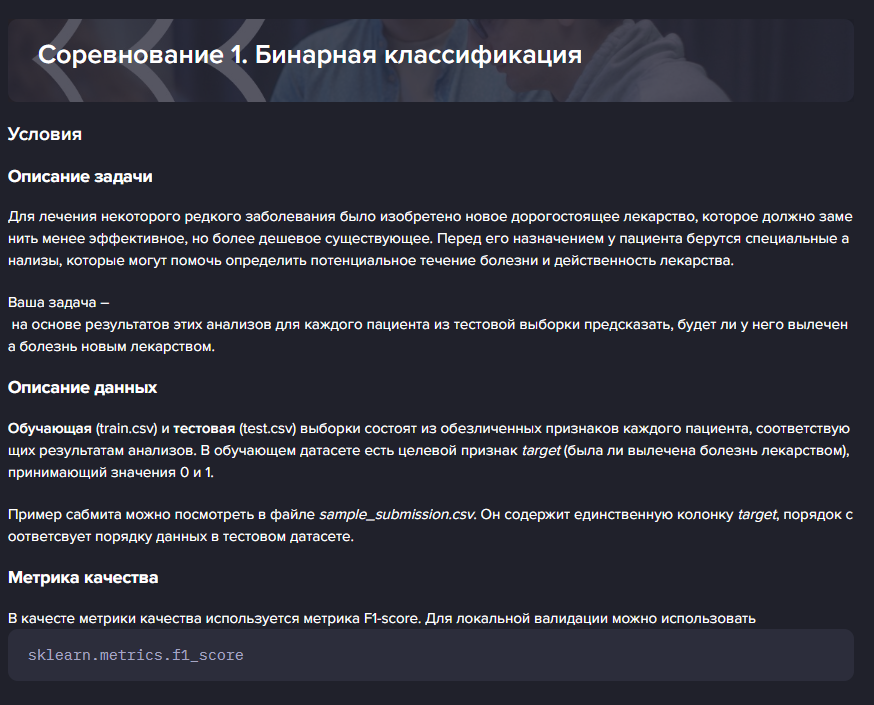

Подгружаем библиотеки

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Загружаем входные данные

In [ ]:
# Подключение Гугл-диска
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
PATH = "drive/MyDrive/Colab Notebooks/MADE/Task 1/"
train_filename = PATH + "train.csv"
test_filename = PATH + "test.csv"
predict_filename = PATH + "sample_submission.csv"
train_filename, test_filename, predict_filename

('drive/MyDrive/Colab Notebooks/MADE/Task 1/train.csv',
 'drive/MyDrive/Colab Notebooks/MADE/Task 1/test.csv',
 'drive/MyDrive/Colab Notebooks/MADE/Task 1/sample_submission.csv')

# Дополнительные функции по обработке данных

In [ ]:
# Переводим Y (таргет) из числа в категории
def int_to_category(y_target):
    y_category = []
    for y in y_target:
        if y == 1:
            y_category.append([0.0, 1.0])
        else:
            y_category.append([1.0, 0.0])
    y_category = np.array(y_category)
    return y_category


# Переводим Y (таргет) из категории в число
def category_to_int(predicts):
    y_predicts = []
    for predict in predicts:
        if predict[1] > predict[0]:
            y_predicts.append(1)
        else:
            y_predicts.append(0)
    y_predicts = np.array(y_predicts)
    return y_predicts

# Загружаем обучаюущую выборку

Загружаем обучающие примеры

In [ ]:
df = pd.read_csv(train_filename, sep=",", decimal=".")
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,target
0,-6.130724,7.429628,3.651437,-1.950971,-3.384415,1.095934,-3.077774,-2.619091,5.128201,1.228476,...,0.392978,4.920467,16.610460,-2.430804,-1.405573,18.610209,-4.140715,6.027816,-20.288145,0
1,5.161836,-6.514011,-7.474612,-4.544336,-13.081404,1.637562,-1.094672,-1.253545,-2.955342,-10.958200,...,-4.840233,-0.514308,4.613289,2.391302,-4.795664,4.208278,-2.017168,-8.510424,10.806639,0
2,-2.971550,-21.508184,-1.125457,1.524129,3.027444,1.045879,1.551050,1.512075,-1.955564,3.683893,...,-0.385303,2.647917,-2.200556,1.058671,1.076312,-7.802389,-7.553953,0.636639,14.274950,0


# Анализируем входные данные


Общие сведения по данным

In [ ]:
pd.set_option("display.max_columns", None)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,target
count,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000
mean,-0.008188,0.046069,0.084133,-0.034631,-0.014021,1.537025,0.115259,-0.086073,0.029376,0.241310,0.028899,0.043639,-0.028667,-0.085202,0.053368,-0.114043,-0.015119,-0.071065,-0.007718,0.131916,-0.059464,0.346143,-0.097963,0.025496,0.029191,-0.009160,0.003571,0.158798,0.064066,-0.205739,-0.122300,0.287233
std,3.057552,6.858400,2.695550,2.765791,7.261945,0.441206,2.762552,2.742284,2.748676,5.454805,2.634640,2.807388,2.767389,2.690851,2.844105,6.774564,2.594378,2.697120,2.626975,2.827084,2.694680,7.904890,2.911122,6.131952,7.884183,2.725234,2.752172,5.803769,2.779181,6.522376,6.802771,0.452503
min,-11.852801,-27.841715,-10.613443,-10.931017,-28.752811,1.000020,-10.311434,-10.075589,-10.141371,-19.277277,-9.889776,-9.955419,-11.329705,-9.805572,-11.405247,-27.056176,-12.171779,-10.031143,-10.782541,-11.053150,-10.338682,-34.791202,-10.638970,-28.953492,-33.201209,-11.850828,-9.478779,-20.325866,-9.926252,-28.539398,-28.483072,0.000000
25%,-2.062561,-4.317894,-1.740497,-1.896934,-4.743647,1.189318,-1.703177,-1.950722,-1.846900,-3.445588,-1.775105,-1.813894,-1.853137,-1.854818,-1.812735,-4.520989,-1.721685,-1.855818,-1.832709,-1.720996,-1.852201,-4.736859,-2.078737,-3.974946,-5.151041,-1.844369,-1.902487,-3.784460,-1.790703,-4.666848,-4.573261,0.000000
50%,-0.017501,-0.053759,0.084710,-0.075840,-0.091840,1.414150,0.143693,-0.063503,0.063927,0.261190,0.012653,0.048777,-0.016087,-0.106418,0.072019,0.033509,-0.055123,-0.018105,-0.051013,0.140333,-0.092508,0.488598,-0.088714,-0.008010,-0.050073,-0.007633,-0.007796,0.166533,0.027659,-0.234126,-0.093245,0.000000
75%,1.991994,4.245097,1.921483,1.777565,4.788682,1.759918,1.964735,1.786275,1.892030,3.906689,1.801128,1.910688,1.801349,1.668930,1.990194,4.414330,1.721335,1.755049,1.729322,2.023719,1.729231,5.481397,1.921656,4.007312,5.322672,1.840979,1.833849,4.026855,1.931042,4.296710,4.339118,1.000000
max,12.902967,34.619762,9.492417,11.881847,26.337084,2.717640,10.887146,10.071861,10.213687,21.919386,10.559548,10.927717,9.737808,10.091910,11.104197,29.892722,10.638206,9.721543,9.837796,11.758651,9.383699,37.615959,11.498217,26.914131,36.333892,9.047867,11.195738,22.448674,9.925644,27.139111,26.071364,1.000000


Проверка на отсутствие данных (isnull)

In [ ]:
for column in df:
    if df[column].isna().sum() > 0:
        print(
            f"Column name: {column} - содержит нулевые данные в кол-ве: {df[column].isna().sum()}"
        )

## Анализ гистрограмм

Можно наблюдать:
- Не нормальное распределение в данных для признака "5" 
- Данные признака "5" распределены ровно между целевыми значениями (видна сильная зависимость/корреляция)

Column name: 0


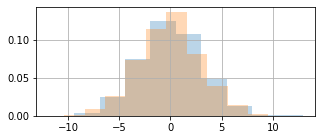

Column name: 1


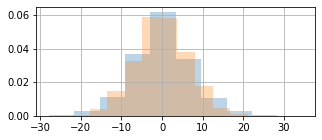

Column name: 2


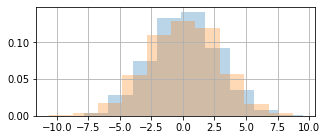

Column name: 3


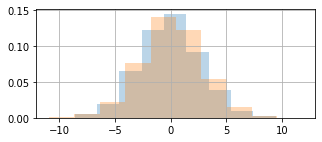

Column name: 4


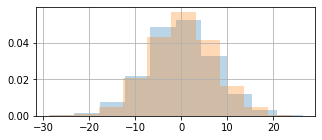

Column name: 5


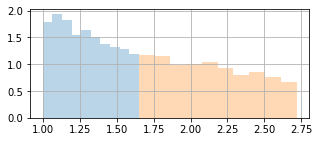

Column name: 6


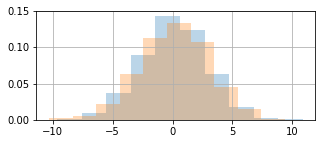

Column name: 7


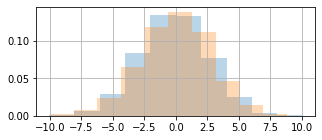

Column name: 8


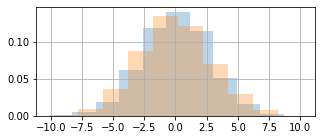

Column name: 9


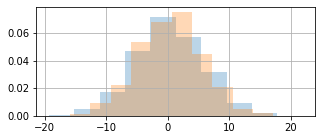

Column name: 10


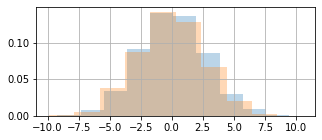

Column name: 11


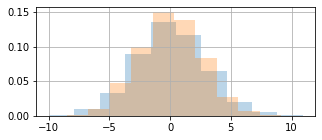

Column name: 12


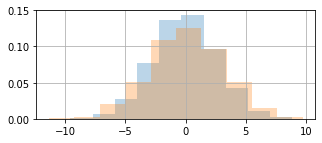

Column name: 13


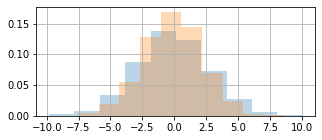

Column name: 14


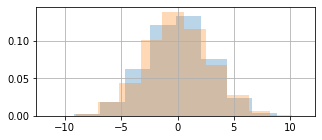

Column name: 15


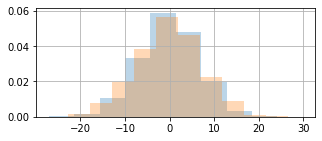

Column name: 16


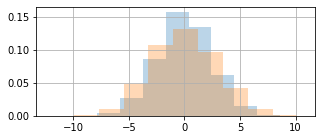

Column name: 17


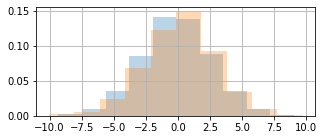

Column name: 18


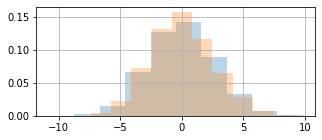

Column name: 19


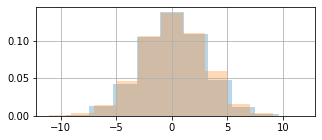

Column name: 20


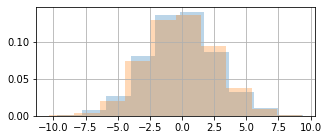

Column name: 21


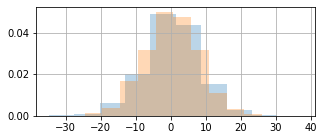

Column name: 22


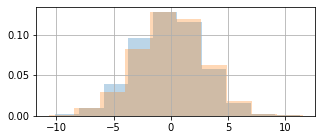

Column name: 23


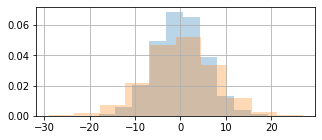

Column name: 24


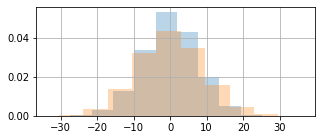

Column name: 25


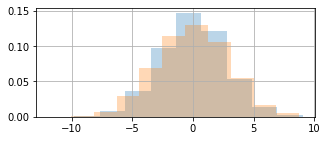

Column name: 26


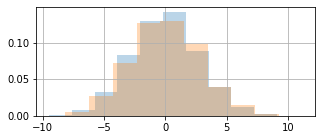

Column name: 27


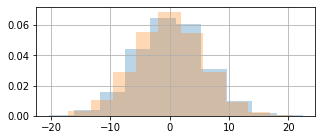

Column name: 28


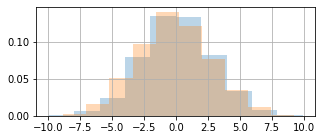

Column name: 29


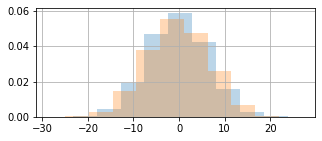

Column name: 30


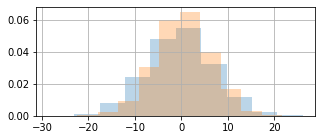

Column name: target


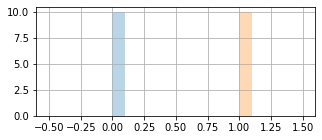

In [ ]:
# Распределение значений в параметрах относительно целевых значений "target"
for column in df:
    print(f"Column name: {column}")
    df.groupby("target")[column].hist(bins=10, alpha=0.3, density=True, figsize=(5, 2))
    plt.show()
# можно наблюдать некорректное поведение в данных для 5го признака. Данные ровно распределены между целевыми значениями

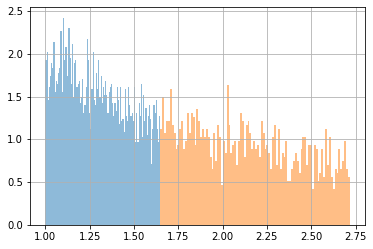

In [ ]:
df.groupby("target")["5"].hist(bins=100, alpha=0.5, density=True)
# df.hist(column=column, by="target", figsize=(5,2))
plt.show()

## Анализ корреляции всех параметров

Явно выделена сильная корреляция признака "5" с целевым значением "target"

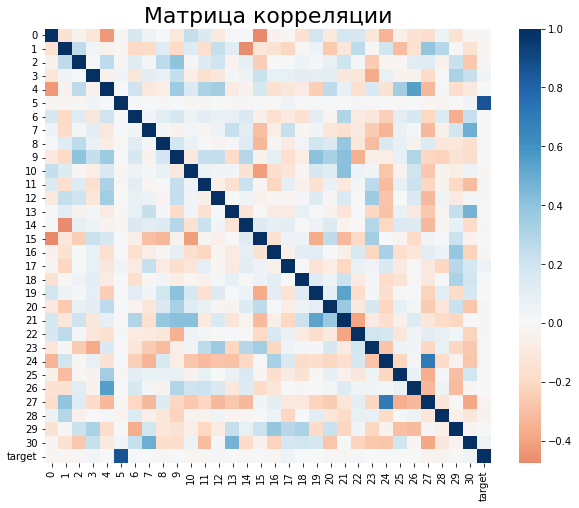

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    df.corr(),
    xticklabels=df.corr().columns,
    yticklabels=df.corr().columns,
    cmap="RdBu",
    center=0,
)

plt.title("Матрица корреляции", fontsize=22)
plt.show()

## Q-Q Plots
Материал по QQ: 
- https://habr.com/ru/post/578754/ 
- https://habr.com/ru/post/556042/

Анализ на: 
- Распределение данных должно быть максимально приближено к прямой главного тренда
- Если оба конца квантильного графика находятся выше прямой главного тренда, то скорее всего это распределение скошено вправо.
- Если оба конца квантильного графика находится ниже прямой главного тренда, то скорее всего это распределение скошено влево.

- Признак "5" вместо нормального распределения имеет равномерное распределения (это и по гистрограмме было видно)
- Признаки 12, 16, 23 имеют незначительные отклонения, но в целом все признаки (кроме 5) показывают хорошую склонность к нормальному распределению

Column name: 0
Ассиметрия: 0.03296628872465666


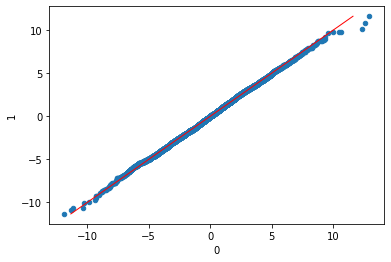

Column name: 1
Ассиметрия: 0.08793700894723874


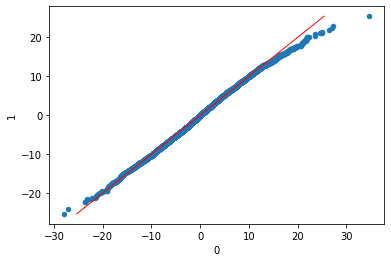

Column name: 10
Ассиметрия: 0.03454381357369091


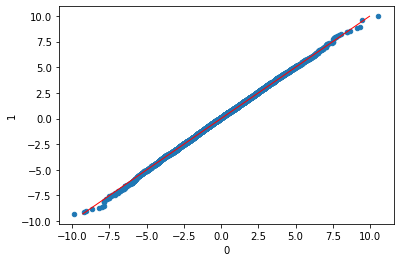

Column name: 11
Ассиметрия: 0.0390303221364168


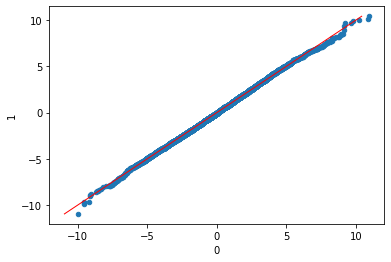

Column name: 12
Ассиметрия: -0.0516570296172716


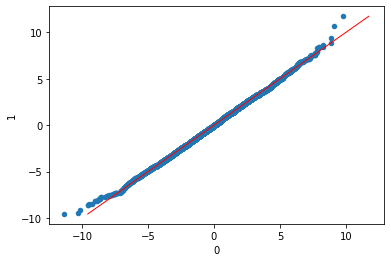

Column name: 13
Ассиметрия: 0.025637479459794076


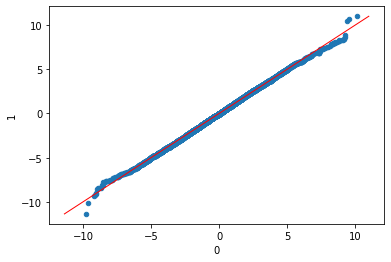

Column name: 14
Ассиметрия: -0.039668874344051204


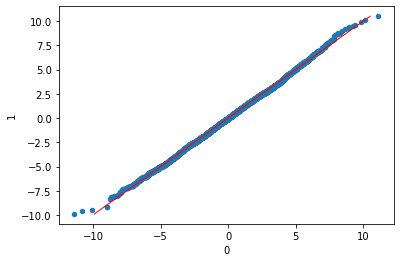

Column name: 15
Ассиметрия: -0.0648685782470896


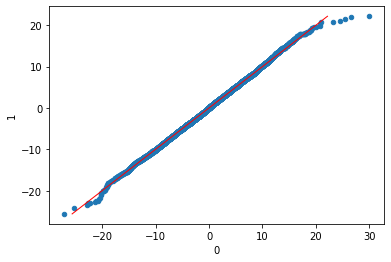

Column name: 16
Ассиметрия: 0.01869794560341374


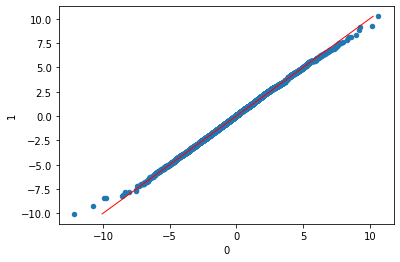

Column name: 17
Ассиметрия: -0.08141806231456662


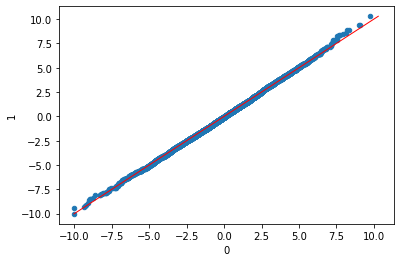

Column name: 18
Ассиметрия: 0.09229978747644842


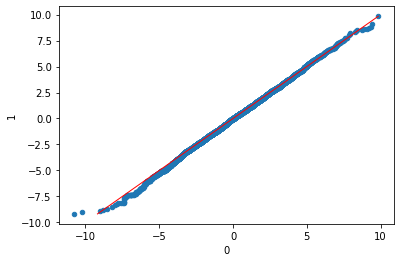

Column name: 19
Ассиметрия: -0.015909517072339098


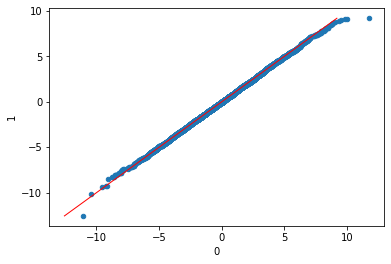

Column name: 2
Ассиметрия: -0.010923554881554753


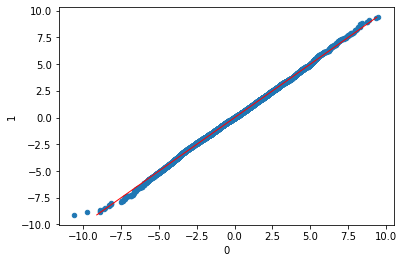

Column name: 20
Ассиметрия: 0.016979216781883737


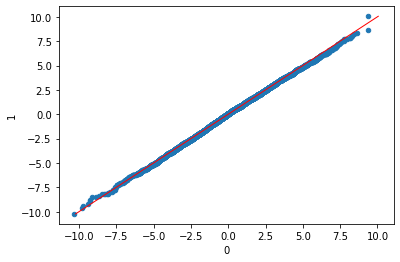

Column name: 21
Ассиметрия: -0.07581656553987544


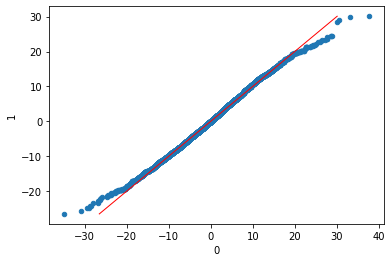

Column name: 22
Ассиметрия: -0.035340216616328614


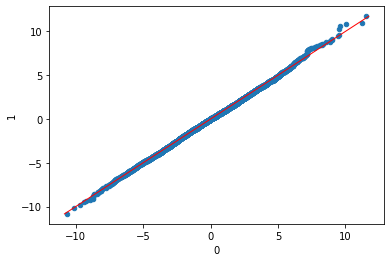

Column name: 23
Ассиметрия: 0.006718915113668054


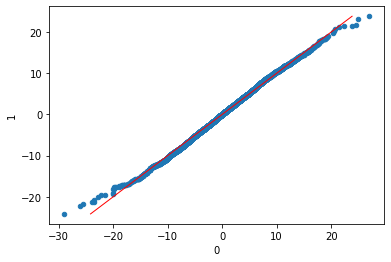

Column name: 24
Ассиметрия: 0.010204739562010819


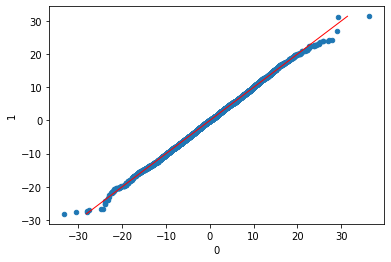

Column name: 25
Ассиметрия: -0.027412158414649584


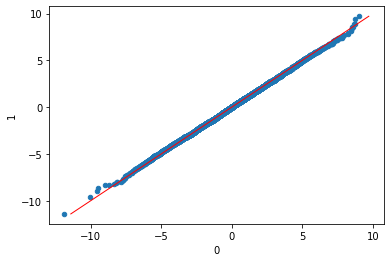

Column name: 26
Ассиметрия: 0.058958738897398257


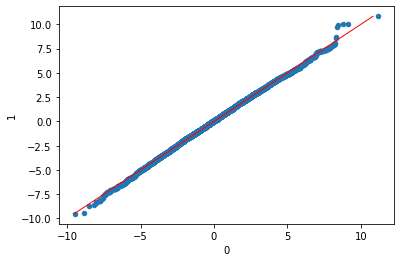

Column name: 27
Ассиметрия: 0.041054910284698064


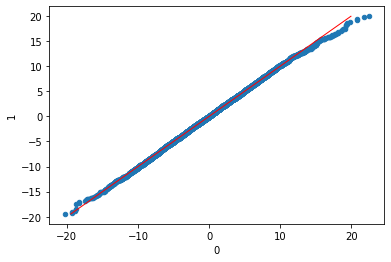

Column name: 28
Ассиметрия: 0.021992261980070524


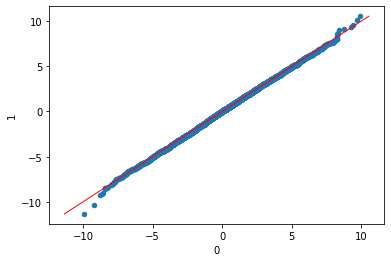

Column name: 29
Ассиметрия: -0.017652674475679923


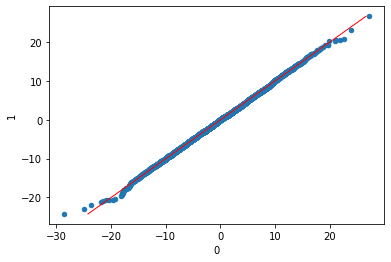

Column name: 3
Ассиметрия: 0.041824051274316744


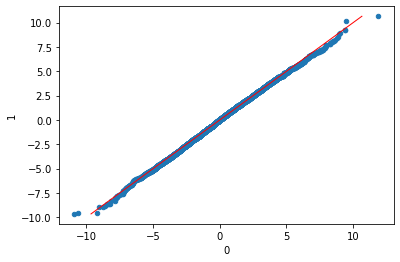

Column name: 30
Ассиметрия: -0.05052446040993273


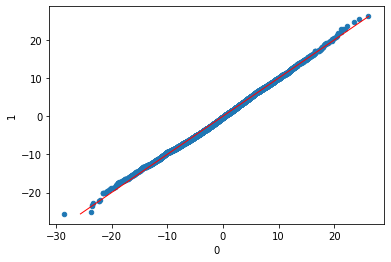

Column name: 4
Ассиметрия: 0.021534491707486406


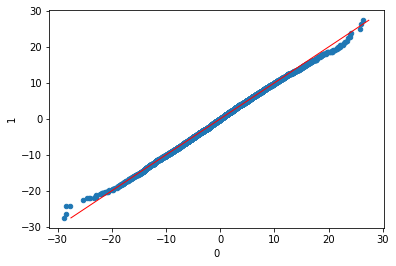

Column name: 5
Ассиметрия: 0.9775776529377949


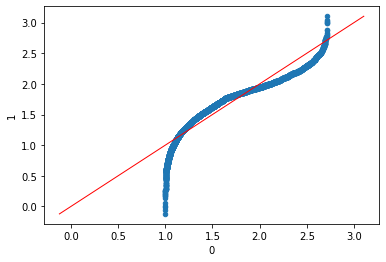

Column name: 6
Ассиметрия: -0.07098575707600753


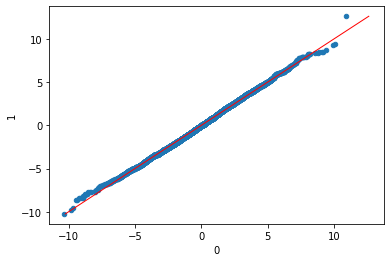

Column name: 7
Ассиметрия: -0.037243942278113625


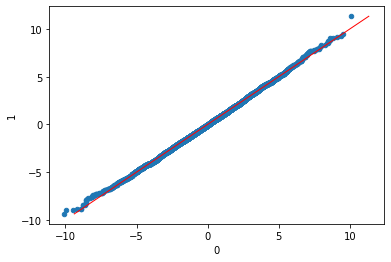

Column name: 8
Ассиметрия: -0.03832313416777868


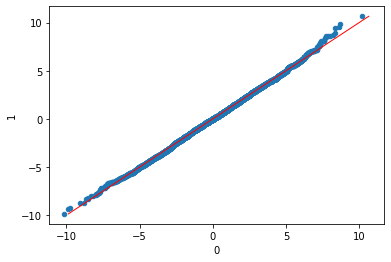

Column name: 9
Ассиметрия: 0.003110814407923231


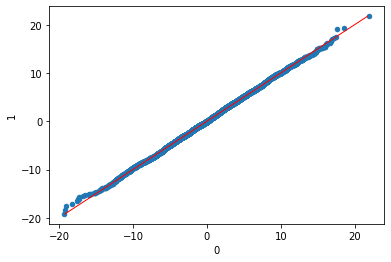

In [ ]:
import scipy
from scipy.stats import norm


# Распределение значений в параметрах относительно целевых значений "target"
for column in df[df.columns.difference(["target"])]:
    print(f"Column name: {column}")
    print(f"Ассиметрия: {df[column].skew()}")

    # При построении нормального распределения используется среднее(mean) и отклонение (std) такие же как и в самих данных, но это не обязательно делать.
    # По сути дял визуальной оценки можно укывать любые данные, графическое предствление не сильно измениться и поведение QQ графиков будет видно
    normal = scipy.stats.norm.rvs(
        loc=df[column].mean(), scale=df[column].std(), size=df[column].shape[0]
    )
    qq = pd.DataFrame({"0": sorted(df[column]), "1": sorted(normal)})
    ax = qq.plot.scatter(0, 1)
    ax.plot(
        [normal.min(), normal.max()], [normal.min(), normal.max()], "r", linewidth=1
    )  # Линия QQ графика при нормальном распределении
    plt.show()

## Cumulative Distribution Function (CDF)
Кумулятивная функция распределения, описывают вероятность, что значение, взятое из распределения, будет меньше x.

Column name: 0
0


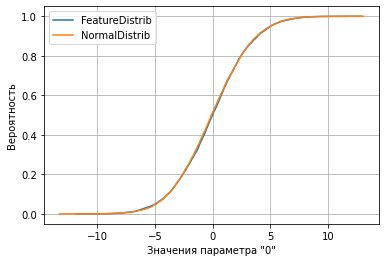

Column name: 1
0


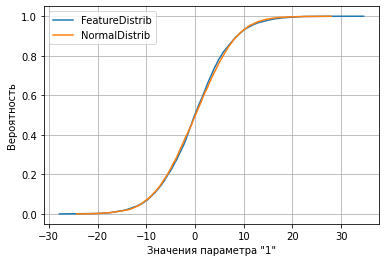

Column name: 10
0


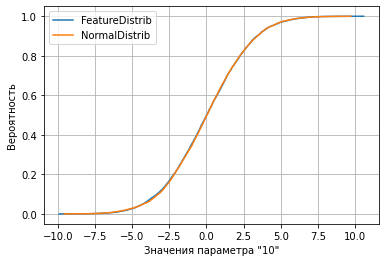

Column name: 11
0


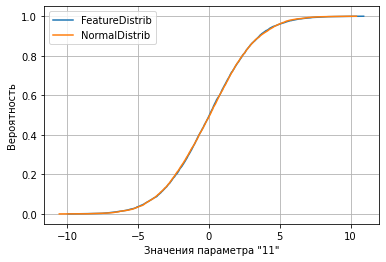

Column name: 12
0


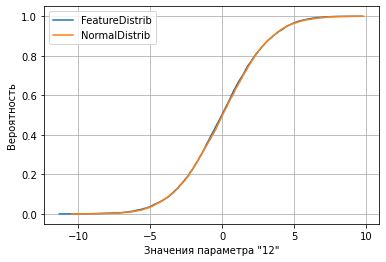

Column name: 13
0


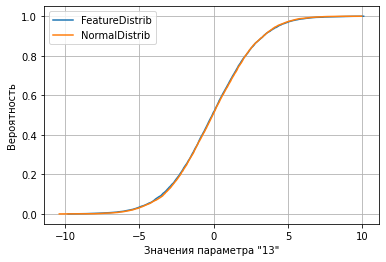

Column name: 14
0


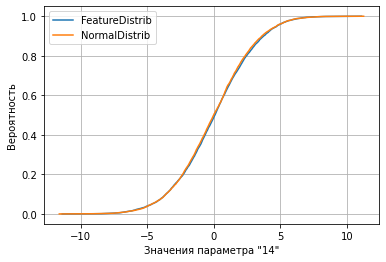

Column name: 15
0


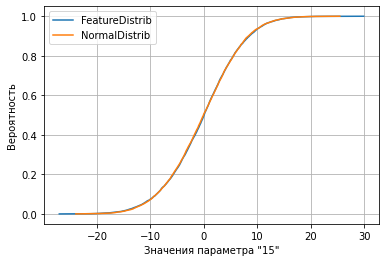

Column name: 16
0


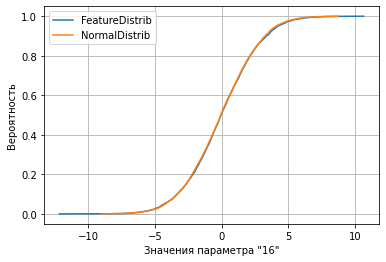

Column name: 17
0


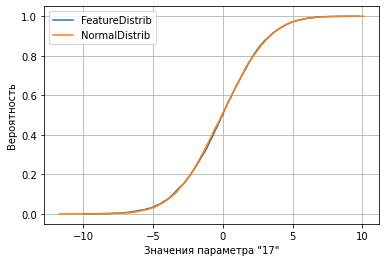

Column name: 18
0


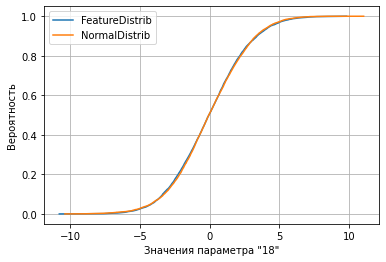

Column name: 19
0


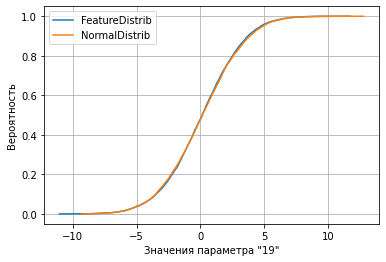

Column name: 2
0


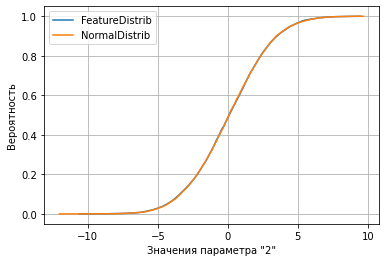

Column name: 20
0


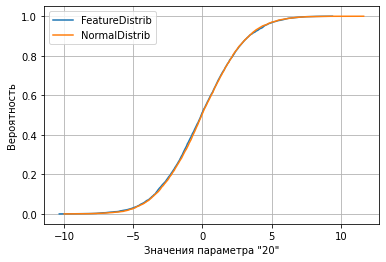

Column name: 21
0


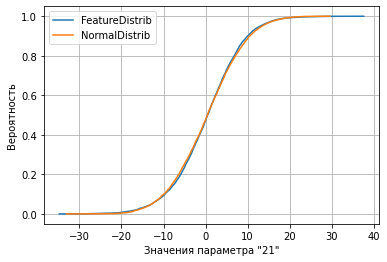

Column name: 22
0


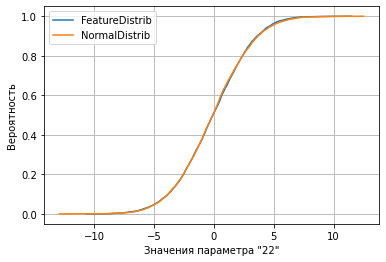

Column name: 23
0


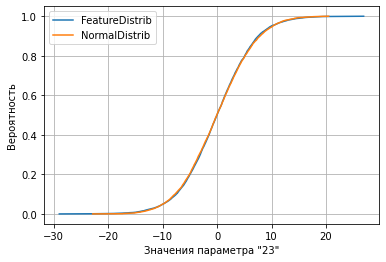

Column name: 24
0


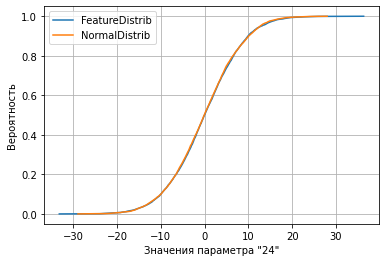

Column name: 25
0


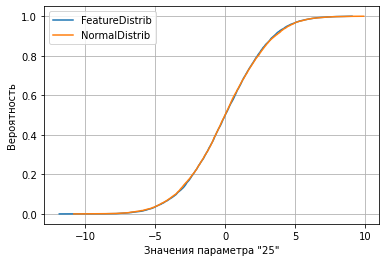

Column name: 26
0


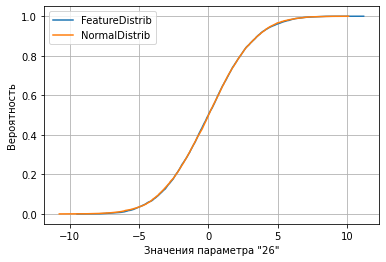

Column name: 27
0


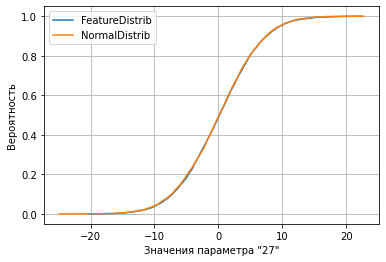

Column name: 28
0


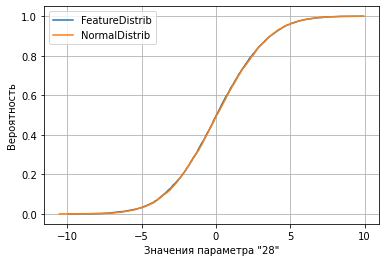

Column name: 29
0


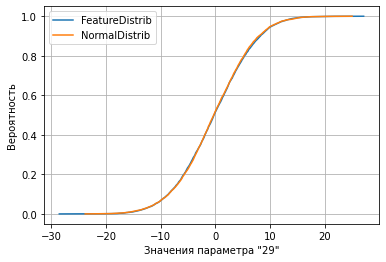

Column name: 3
0


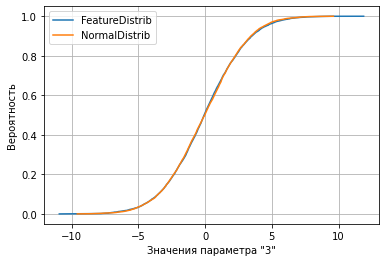

Column name: 30
0


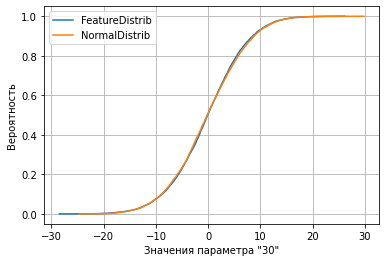

Column name: 4
0


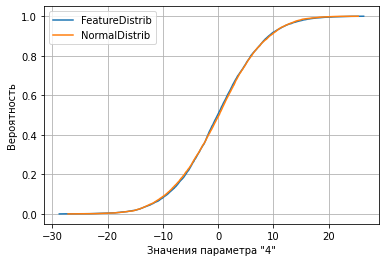

Column name: 5
0


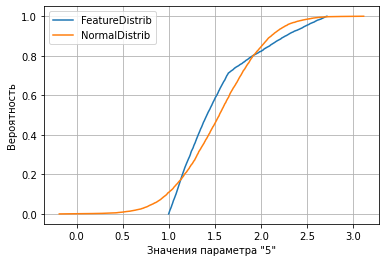

Column name: 6
0


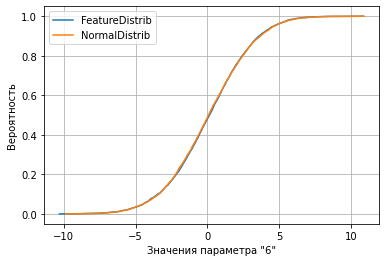

Column name: 7
0


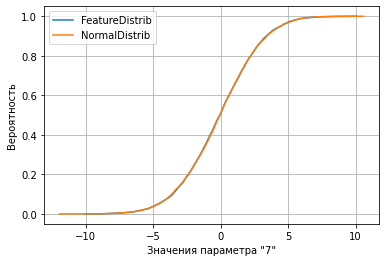

Column name: 8
0


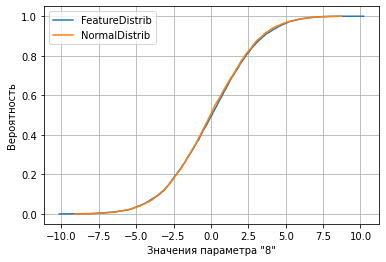

Column name: 9
0


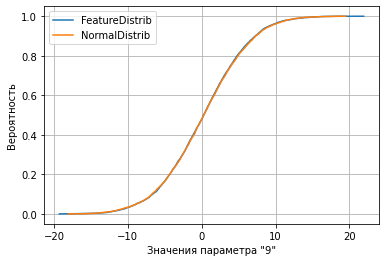

In [ ]:
import scipy
from scipy.stats import norm

# Распределение значений в параметрах относительно целевых значений "target"
for column in df[df.columns.difference(["target"])]:
    print(f"Column name: {column}")
    # print(Counter(df[column].isnull())[True])
    x = sorted(df[column])
    y = (np.arange(len(x)) + 1) / len(x)
    normal_distribution = scipy.stats.norm.rvs(
        loc=df[column].mean(), scale=df[column].std(), size=df[column].shape[0]
    )
    x_normal_dist = sorted(normal_distribution)
    y_normal_dist = np.arange(1, len(x_normal_dist) + 1) / len(x_normal_dist)
    # normal_cdf = pd.DataFrame({"0": x_normal_dist, "1":y_normal_dist})
    # cdf = pd.DataFrame({"0": x, "1":y})
    plt.plot(x, y, label="FeatureDistrib")
    plt.plot(x_normal_dist, y_normal_dist, label="NormalDistrib")
    plt.legend()
    plt.ylabel("Вероятность")
    plt.xlabel(f'Значения параметра "{column}"')
    plt.grid()
    plt.show()

### Ассиметрия признаков
Асимметрией называется смещение распределения относительно ее моды
Асимметрия — это мера асимметрии распределения вероятностей действительнозначной случайной величины относительно ее среднего значения. 

Насколько сильно распредленеие не соответсвует нормальному

https://www.geeksforgeeks.org/python-pandas-dataframe-skew/


In [ ]:
# Асимметрия — это мера асимметрии распределения вероятностей действительнозначной случайной величины относительно ее среднего значения.
pd.DataFrame(df.skew().sort_values(ascending=False))

,0
5,0.977578
target,0.940672
18,0.092300
1,0.087937
26,0.058959
3,0.041824
27,0.041055
11,0.039030
10,0.034544
0,0.032966


## Определение кол-во таргетов

In [ ]:
from collections import Counter

# Кол-во каждого вида таргета
Counter(df["target"])
# Таргетов "0" в 2,5 раза больше чем тарегтов "1"

Counter({0: 4963, 1: 2000})

# Анализ параметров через быстрое обучение на простой модели

По итогам анализа параметров на простой модели можно сделать вывод, что:
- Обучение только с параметром "5" дает 98% точности
- Обучение без параметра "5" дает самую низкую точность 93%
- Средняя точность обучения на одном параметре составляет 71%
- Средняя точность обучения на всех кроме одного параметра составляет 98,8%


In [ ]:
class DetectFeatures:
    """Класс для анализа параметров через быстрое обучение на простой модели"""

    def __init__(self, df_x_data, y_data):
        self.df_x_data = df_x_data
        self.train_y_data = y_data

        self.features_accuracy = {}

    def calc_features_accuracy(self):
        for feature_name in self.df_x_data.columns:
            print(f"feature_name: {feature_name}")
            # Прогоняем модель незавсимо по каждому параметру
            x_train, x_val, y_train, y_val = self._calc_target_x([feature_name])
            loss_only_features, accuracy_only_features = self._calc_light_model(
                x_train, x_val, y_train, y_val
            )
            # print(f"Only {feature_name}: {round(accuracy_only_features,2)}")
            if len(self.df_x_data.columns) > 1:
                # Прогоняем модель незавсимо по всем параметрам кроме выбраного (исключаем параметр из обучения)
                x_train, x_val, y_train, y_val = self._calc_target_x(
                    self.df_x_data.loc[
                        :, self.df_x_data.columns != feature_name
                    ].columns
                )
                (
                    loss_without_features,
                    accuracy_without_features,
                ) = self._calc_light_model(x_train, x_val, y_train, y_val)
                # print(f"WithOut {feature_name}: {round(accuracy_without_features,2)}")
            else:
                loss_without_features, accuracy_without_features = 0, 0

            self.features_accuracy[feature_name] = [
                round(accuracy_only_features, 2),
                round(accuracy_without_features, 2),
            ]
            self.df_features = pd.DataFrame.from_dict(
                self.features_accuracy,
                orient="index",
                columns=["Only feature", "WithOut feature"],
            )
        return self.df_features

    def _calc_target_x(self, columns):
        scaler = StandardScaler()
        scaler.fit(self.df_x_data[columns])
        self.train_x_data = scaler.transform(self.df_x_data[columns])

        x_train, x_val, y_train, y_val = train_test_split(
            self.train_x_data, self.train_y_data, test_size=0.2, shuffle=True
        )
        # print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
        # print(x_train[None].shape, x_val[None].shape, y_train.shape, y_val.shape)
        return x_train, x_val, y_train, y_val

    def _calc_light_model(self, x_train, x_val, y_train, y_val):
        self.model = Sequential()
        self.model.add(Dense(200, input_shape=(x_train.shape[1:]), activation="relu"))
        self.model.add(Dense(50, activation="relu"))
        self.model.add(Dense(2, activation="softmax"))
        self.model.compile(
            optimizer="Nadam", loss="binary_crossentropy", metrics=["accuracy"]
        )  # , 'Precision'
        history = self.model.fit(
            x_train,
            y_train,
            epochs=5,
            validation_data=(x_val, y_val),
            verbose=False,
            batch_size=200,
        )
        return history.history["val_loss"][-1], history.history["val_accuracy"][-1]


# # detect_features = DetectFeatures(df[df.columns.difference(['target'])][["5"]], train_y_data ).calc_features_accuracy()
# detect_features = DetectFeatures(df[df.columns.difference(['target'])], train_y_data ).calc_features_accuracy()
# detect_features.describe(), detect_features
# detect_features

# Формируем даные для обучения модели

## Формируем целевые данные (y/target)

Отделяем целевые значниея targeta от входных параметров

**!!! На тестовых данных в системе контроля MADE показан очень score=0.3, при том что точность модели достиагал 98%, необходимо исключить параметр "5"**

In [ ]:
# Изначальный вариант
# Исключаем из train_x значнеия таргета
# train_x_data = df[df.columns.difference(['target'])]

# После уточнения
# !!! На тестовых данных в системе контроля MADE показан очень score=0.3, при том что точность модели достиагал 98%, необходимо исключить параметр "5"
# После анализа исключаем из train_x значнеия таргета и параметр "5"
train_x_data = df[df.columns.difference(["target", "5"])]
train_y_data = df["target"]
train_x_data.shape, train_y_data.shape

((6963, 30), (6963,))

Формируем Target в категорийный тип данных вместо 0/1 будет [[1,0], [0,1]]

In [ ]:
train_y_data = int_to_category(train_y_data)
train_y_data.shape

(6963, 2)

## Формируем входные параметры (x/features)

Нормализуем данные входных параметров

In [ ]:
scaler = StandardScaler()
scaler.fit(train_x_data)
train_x_data = scaler.transform(train_x_data)
train_x_data.shape

(6963, 30)

In [ ]:
np.min(train_x_data), np.max(train_x_data)

(-4.726238391296831, 5.041434549680561)

##Разбиваем выборку на обучающую и на валидационную

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    train_x_data, train_y_data, test_size=0.2, shuffle=True
)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5570, 30), (1393, 30), (5570, 2), (1393, 2))

##Обучаем модель

(30,)
Epoch 1/50
28/28 [==============================] - 1s 10ms/step - loss: 0.6128 - accuracy: 0.6548 - val_loss: 0.5258 - val_accuracy: 0.7243
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.4766 - accuracy: 0.7668 - val_loss: 0.3952 - val_accuracy: 0.8356
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 0.3400 - accuracy: 0.8727 - val_loss: 0.2768 - val_accuracy: 0.8966
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.2385 - accuracy: 0.9127 - val_loss: 0.2118 - val_accuracy: 0.9275
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 0.1835 - accuracy: 0.9334 - val_loss: 0.1807 - val_accuracy: 0.9296
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.1531 - accuracy: 0.9418 - val_loss: 0.1569 - val_accuracy: 0.9397
Epoch 7/50
28/28 [==============================] - 0s 4ms/step - loss: 0.1333 - accuracy: 0.9530 - val_loss: 0.1488 - val_accuracy: 0.9469
Epoch 8/50
28

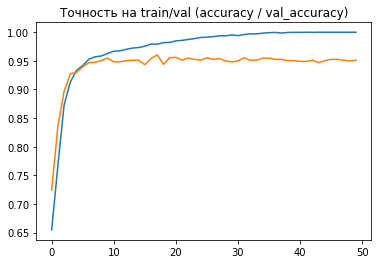

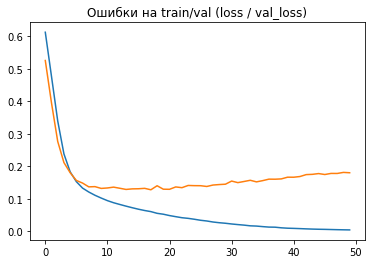

In [ ]:
print(x_train.shape[1:])
model = Sequential()
model.add(Dense(200, input_shape=(x_train.shape[1:]), activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(
    optimizer="Nadam", loss="binary_crossentropy", metrics=["accuracy"]
)  # , 'Precision'
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    verbose=True,
    batch_size=200,
)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Точность на train/val (accuracy / val_accuracy)")
plt.show()

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Ошибки на train/val (loss / val_loss)")
plt.show()

# Формируем прогноз для тестовых данных

Загружаем тестовый датасет

In [ ]:
df_test = pd.read_csv(test_filename, sep=",", decimal=".")
# Исключаем из тестовых данных параметр "5"
df_test = df_test[df_test.columns.difference(["5"])]
df_test.head(3)

,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,4,6,7,8,9
0,-4.768975,-1.744984,0.786596,-1.328847,5.288757,-4.737839,3.649170,14.484535,-1.411516,-1.769634,-5.142591,-5.376967,0.069141,3.754266,4.198756,-0.625212,11.053370,1.535982,0.410761,-3.754269,8.633258,0.224213,-2.310344,-6.560182,-20.482680,13.267557,1.711161,-5.289421,2.682271,-2.763065
1,3.085184,7.679585,3.604735,-3.506214,-2.690967,3.700439,-3.200376,2.998509,-2.178400,-1.000082,2.287349,1.085944,-2.392444,-4.877813,-1.176409,1.365061,0.140867,-4.210869,-5.718286,-4.055603,9.264081,-4.221163,7.481250,-1.334928,9.426657,-17.347661,-0.662081,-0.719648,-2.489930,-11.762400
2,-1.498828,-3.945847,-3.443283,2.469729,0.392571,-1.533060,2.753245,4.753303,-1.178234,-1.592556,0.221993,-0.029546,-1.647106,-1.716968,0.301051,0.758360,0.090010,-1.550171,-0.971835,2.027758,-2.723663,0.749390,-12.130969,0.058655,4.706467,1.204024,5.246244,2.123335,2.851375,4.398413


Формируем предикт

In [ ]:
# Нормализируем тестовые данные для подачи в модель
df_test = scaler.transform(df_test)
# Формируем предикты по тестовым данным
predicts = model.predict(df_test)
# Переводим предсказанные значения из категориального вида в целочисленный (из вида [1,0]/[0,1] в вид 0/1)
predicts = category_to_int(predicts)
predicts.shape

(3920,)

Записываем предикты в итоговый файл

In [ ]:
result_predict_df = pd.DataFrame(predicts, columns=["target"])
result_predict_df.to_csv(predict_filename, index=False)
result_predict_df.shape

(3920, 1)